In [6]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),
    ('order_items.csv' , 'order_items')
]

# Connect to the MySQL database
try:
    conn = mysql.connector.connect(
        host='localhost',
        user='root',
        password='@#Nik0402#@',
        database='ecommerce'
    )
    cursor = conn.cursor()

    # Folder containing the CSV files
    folder_path = r'C:\Users\NIKHIL VIKAS KAMBLE\Downloads\ecommerce'

    def get_sql_type(dtype):
        if pd.api.types.is_integer_dtype(dtype):
            return 'INT'
        elif pd.api.types.is_float_dtype(dtype):
            return 'FLOAT'
        elif pd.api.types.is_bool_dtype(dtype):
            return 'BOOLEAN'
        elif pd.api.types.is_datetime64_any_dtype(dtype):
            return 'DATETIME'
        else:
            return 'TEXT'

    for csv_file, table_name in csv_files:
        file_path = os.path.join(folder_path, csv_file)
        
        # Read the CSV file into a pandas DataFrame
        df = pd.read_csv(file_path)
        
        # Replace NaN with None to handle SQL NULL
        df = df.where(pd.notnull(df), None)
        
        # Debugging: Check for NaN values
        print(f"Processing {csv_file}")
        print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

        # Clean column names
        df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

        # Generate the CREATE TABLE statement with appropriate data types
        columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
        create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
        cursor.execute(create_table_query)

        # Insert DataFrame data into the MySQL table
        for _, row in df.iterrows():
            # Convert row to tuple and handle NaN/None explicitly
            values = tuple(None if pd.isna(x) else x for x in row)
            sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
            cursor.execute(sql, values)

        # Commit the transaction for the current CSV file
        conn.commit()

except mysql.connector.Error as err:
    print(f"Error: {err}")
    if conn.is_connected():
        conn.rollback()  # Rollback in case of error

finally:
    if conn.is_connected():
        cursor.close()
        conn.close()
        print("MySQL connection is closed")



Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import numpy as np


db = mysql.connector.connect(
    host = "localhost",
    username = "root",
    password = "@#Nik0402#@",
    database = "ecommerce")
cur = db.cursor()


# list all the unique cities where customers are located

In [7]:
query = """select distinct customer_city from customers"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df.head()

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# count the number of orders placed in 2017.

In [6]:
query = """select count(order_id) from orders where year (order_purchase_timestamp) = 2017"""

cur.execute(query)
data = cur.fetchall()
("total orders placed in 2017 are ", data[0][0])

('total orders placed in 2017 are ', 45101)

# Find the total sales per category.

In [5]:
query = """SELECT 
    upper(products.product_category) AS category, 
    ROUND(SUM(payments.payment_value), 2) AS sales
FROM 
    products 
JOIN 
    order_items ON products.product_id = order_items.product_id
JOIN 
    payments ON payments.order_id = order_items.order_id
GROUP BY 
    category;"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data , columns = ["Category" , "Sales"])
df

,Category,Sales
0,PERFUMERY,506738.66
1,FURNITURE DECORATION,1430176.39
2,TELEPHONY,486882.05
3,BED TABLE BATH,1712553.67
4,AUTOMOTIVE,852294.33
...,...,...
69,CDS MUSIC DVDS,1199.43
70,LA CUISINE,2913.53
71,FASHION CHILDREN'S CLOTHING,785.67
72,PC GAMER,2174.43


# Calculate the percentage of orders that were paid in installments.

In [4]:
query = """select (sum(case when payment_installments >=1 then 1
else 0 end)) / count(*) *100 from payments """

cur.execute(query)
data = cur.fetchall()
"the percentage of orders that were paid in installments =" ,data [0][0]

('the percentage of orders that were paid in installments =',
 Decimal('99.9981'))

# Count the number of customers from each state. 

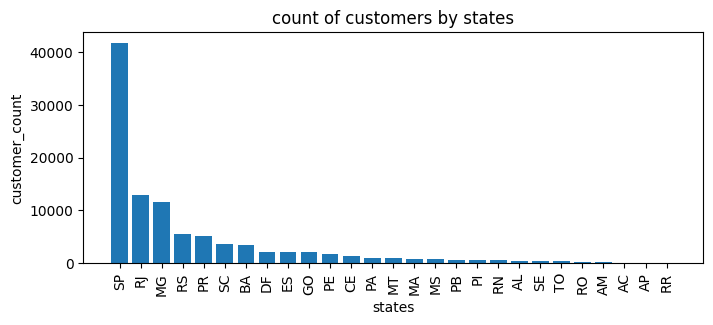

In [21]:
query = """select customer_state,  count(customer_id) 
from customers group by customer_state"""

cur.execute(query)
data = cur.fetchall()
# using pandas to create dataframes
df = pd.DataFrame(data , columns = ["state", "customer_count"])
df= df.sort_values(by = "customer_count" , ascending = False )

# using matplotlib to creat bar chart
plt.figure(figsize = (8,3))
plt.bar(df["state"], df["customer_count"])
plt.xticks(rotation = 90)
plt.xlabel("states")
plt.ylabel("customer_count")
plt.title("count of customers by states")
plt.show()

# Calculate the number of orders per month in 2018.

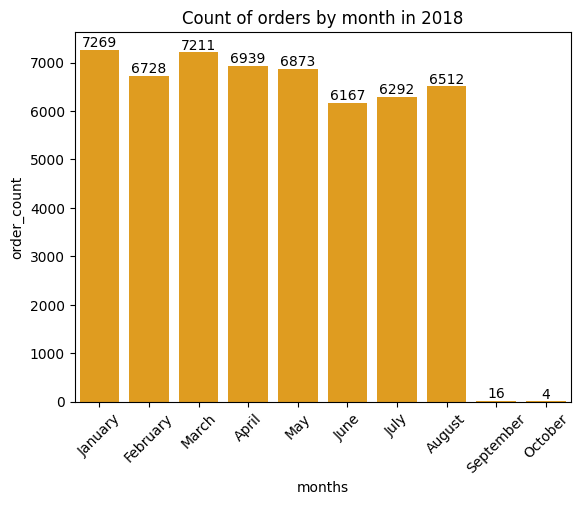

In [24]:
query = """select  monthname(order_purchase_timestamp) as months, count(order_id) as order_count
from orders where year(order_purchase_timestamp) =2018
group by months"""

cur.execute(query)
data = cur.fetchall()
df= pd.DataFrame(data , columns = ["months" , "order_count"])

o = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October"] 
plt.xticks(rotation= 45)
ax = sns.barplot( x = df["months"] , y = df["order_count"] , data = df , order =o , color = "orange" )
ax.bar_label(ax.containers[0])
plt.title("Count of orders by month in 2018")
plt.show()

# Find the average number of products per order, grouped by customer city

In [29]:
query = """  with count_per_order as ( select   orders.order_id , orders.customer_id , count(order_items.order_id) as oc 
from orders join order_items 
on orders.order_id = order_items.order_id
group by orders.order_id , orders.customer_id)
select customers.customer_city , round(avg(count_per_order.oc ), 2 ) as avg_orders
from customers join count_per_order 
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city order by avg_orders desc"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data , columns = ["customer_city" , "Avg_pdoducts_per_orders"]) 
df.head(10)

,customer_city,Avg_pdoducts_per_orders
0,padre carvalho,7.00
1,celso ramos,6.50
2,datas,6.00
3,candido godoi,6.00
4,matias olimpio,5.00
5,cidelandia,4.00
6,picarra,4.00
7,morro de sao paulo,4.00
8,teixeira soares,4.00
9,curralinho,4.00


# Calculate the percentage of total revenue contributed by each product category

In [33]:
query = """SELECT upper(products.product_category) AS category, round((SUM(payments.payment_value)/ (select sum(payment_value) from payments))*100, 2) AS percentage_sales
FROM 
    products 
JOIN 
    order_items ON products.product_id = order_items.product_id
JOIN 
    payments ON payments.order_id = order_items.order_id
GROUP BY 
    category 
    Order by percentage_sales DESC"""

cur.execute(query)
data = cur.fetchall()
df=pd.DataFrame(data , columns = ["product_category" , "Percentage_sales"])
df.head(10)

,product_category,Percentage_sales
0,BED TABLE BATH,10.70
1,HEALTH BEAUTY,10.35
2,COMPUTER ACCESSORIES,9.90
3,FURNITURE DECORATION,8.93
4,WATCHES PRESENT,8.93
5,SPORT LEISURE,8.70
6,HOUSEWARES,6.84
7,AUTOMOTIVE,5.32
8,GARDEN TOOLS,5.24
9,COOL STUFF,4.87


# Identify the correlation between product price and the number of times a product has been purchased

In [6]:

query = """ 
SELECT 
    products.product_category, 
    COUNT(order_items.product_id) AS order_count, 
    ROUND(AVG(order_items.price), 2) AS avg_price
FROM 
    products 
JOIN 
    order_items ON products.product_id = order_items.product_id
GROUP BY 
    products.product_category 
"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=["Category", "order_count", "avg_price"])

arr1 = df["order_count"].values
arr2 = df["avg_price"].values

correlation = np.corrcoef(arr1, arr2)
print(correlation)


[[ 1.         -0.10631514]
 [-0.10631514  1.        ]]


# Calculate the total revenue generated by each seller, and rank them by revenue.

In [4]:
query = """ 
select * ,dense_rank() over(order by revenue desc)  as rn from 
(SELECT order_items.seller_id , sum(payments.payment_value) as revenue 
from order_items join payments
on order_items.order_id = payments.order_id
group by order_items.seller_id) as sub 
"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=["Seller", "revenue_by_seller", "Ranking"])
df

,Seller,revenue_by_seller,Ranking
0,7c67e1448b00f6e969d365cea6b010ab,507166.907302,1
1,1025f0e2d44d7041d6cf58b6550e0bfa,308222.039840,2
2,4a3ca9315b744ce9f8e9374361493884,301245.269765,3
3,1f50f920176fa81dab994f9023523100,290253.420128,4
4,53243585a1d6dc2643021fd1853d8905,284903.080498,5
...,...,...,...
3090,ad14615bdd492b01b0d97922e87cb87f,19.209999,3082
3091,702835e4b785b67a084280efca355756,18.559999,3083
3092,4965a7002cca77301c82d3f91b82e1a9,16.360001,3084
3093,77128dec4bec4878c37ab7d6169d6f26,15.220000,3085


# Calculate the moving average of order values for each customer over their order history

In [5]:
query = """select customer_id, order_purchase_timestamp, payment,
avg(payment) over(partition by customer_id order by order_purchase_timestamp rows between 2 preceding and current row)as mov_avg
from 
(select orders.customer_id, orders.order_purchase_timestamp, payments.payment_value as payment
from payments join orders
on payments.order_id= orders.order_id)as a"""

cur.execute(query)
data = cur.fetchall()
df= pd.DataFrame(data ,columns=["customer_id", "order_timestamp", "payments", "moving_avg"] )
df


,customer_id,order_timestamp,payments,moving_avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002
...,...,...,...,...
103881,fffecc9f79fd8c764f843e9951b11341,2018-03-29 16:59:26,71.23,27.120001
103882,fffeda5b6d849fbd39689bb92087f431,2018-05-22 13:36:02,63.13,63.130001
103883,ffff42319e9b2d713724ae527742af25,2018-06-13 16:57:05,214.13,214.130005
103884,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.500000


# Calculate the cumulative sales per month for each year.

In [6]:
query= """select years , months ,payment, round(sum(payment) over (order by years, months), 2)as cummulative_sales from 
(select year(orders.order_purchase_timestamp)as years, month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value), 2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years, months
order by years , months ) as a ;"""

cur.execute(query)
data = cur.fetchall()
df= pd.DataFrame(data ,columns=["Year", "Month", "payments", "cummulative_sales"] )
df

,Year,Month,payments,cummulative_sales
0,2016,9,252.24,252.24
1,2016,10,59090.48,59342.72
2,2016,12,19.62,59362.34
3,2017,1,138488.04,197850.38
4,2017,2,291908.01,489758.39
5,2017,3,449863.60,939621.99
6,2017,4,417788.03,1357410.02
7,2017,5,592918.82,1950328.84
8,2017,6,511276.38,2461605.22
9,2017,7,592382.92,3053988.14


# Calculate the year-over-year growth rate of total sales

In [2]:
query = """select years, payment , lag(payment, 1) over (order by years) as prev_year, 
round(((payment-lag(payment, 1) over (order by years))/(lag(payment, 1) over (order by years)))*100,2) as year_over_year
from
(select year(orders.order_purchase_timestamp)as years,
round(sum(payments.payment_value), 2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years
order by years) as a  ;"""

cur.execute(query)
data = cur.fetchall()
df= pd.DataFrame(data ,columns=["Year", "Curr_year_sales", "prev_year_sales", "Y_over__%sales"] )
df


,Year,Curr_year_sales,prev_year_sales,Y_over__%sales
0,2016,59362.34,NaN,NaN
1,2017,7249746.73,59362.34,12112.7
2,2018,8699763.05,7249746.73,20.0


# Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase

In [3]:
query ="""with a as (select customers.customer_id, min(orders.order_purchase_timestamp) as first_order
from customers join orders
on customers.customer_id = orders.customer_id
group by customers.customer_id),

 b as (select a.customer_id , count(distinct orders.order_purchase_timestamp) next_order 
from a join orders
on orders.customer_id = a.customer_id
and orders.order_purchase_timestamp > first_order 
and orders.order_purchase_timestamp < date_add(first_order , interval 6 month)
group by a.customer_id)
 select 100 * (count(distinct a.customer_id) / count(distinct b.customer_id) ) 
 from a left join b 
  on a.customer_id = b.customer_id;"""

cur.execute(query)
data = cur.fetchall()
data

[(None,)]

In [ ]:
# since there are no repeating customers in last 6 months we are not getting any value

# Identify the top 3 customers who spent the most money in each year

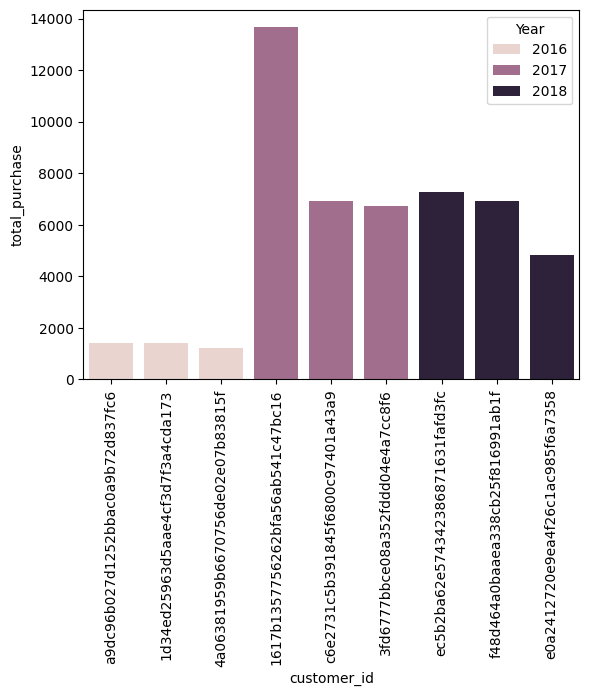

In [9]:
query = """select years , customer_id , payment , d_rank from 
(select year(orders.order_purchase_timestamp) as years   , orders.customer_id, round(sum(payments.payment_value), 2) as payment ,
dense_rank() over ( partition by year(orders.order_purchase_timestamp) order by sum(payments.payment_value) desc ) as d_rank
from orders join payments
on payments.order_id = orders.order_id
group by year(orders.order_purchase_timestamp) , orders.customer_id) as a

where d_rank <=3;"""

cur.execute(query)
data= cur.fetchall()
df= pd.DataFrame(data ,columns=["Year", "customer_id", "total_purchase", "Top3_of_each_year"] )
sns.barplot(x = "customer_id" , y = "total_purchase" , data = df , hue= "Year")
plt.xticks(rotation = 90)
plt.show()